<div>
    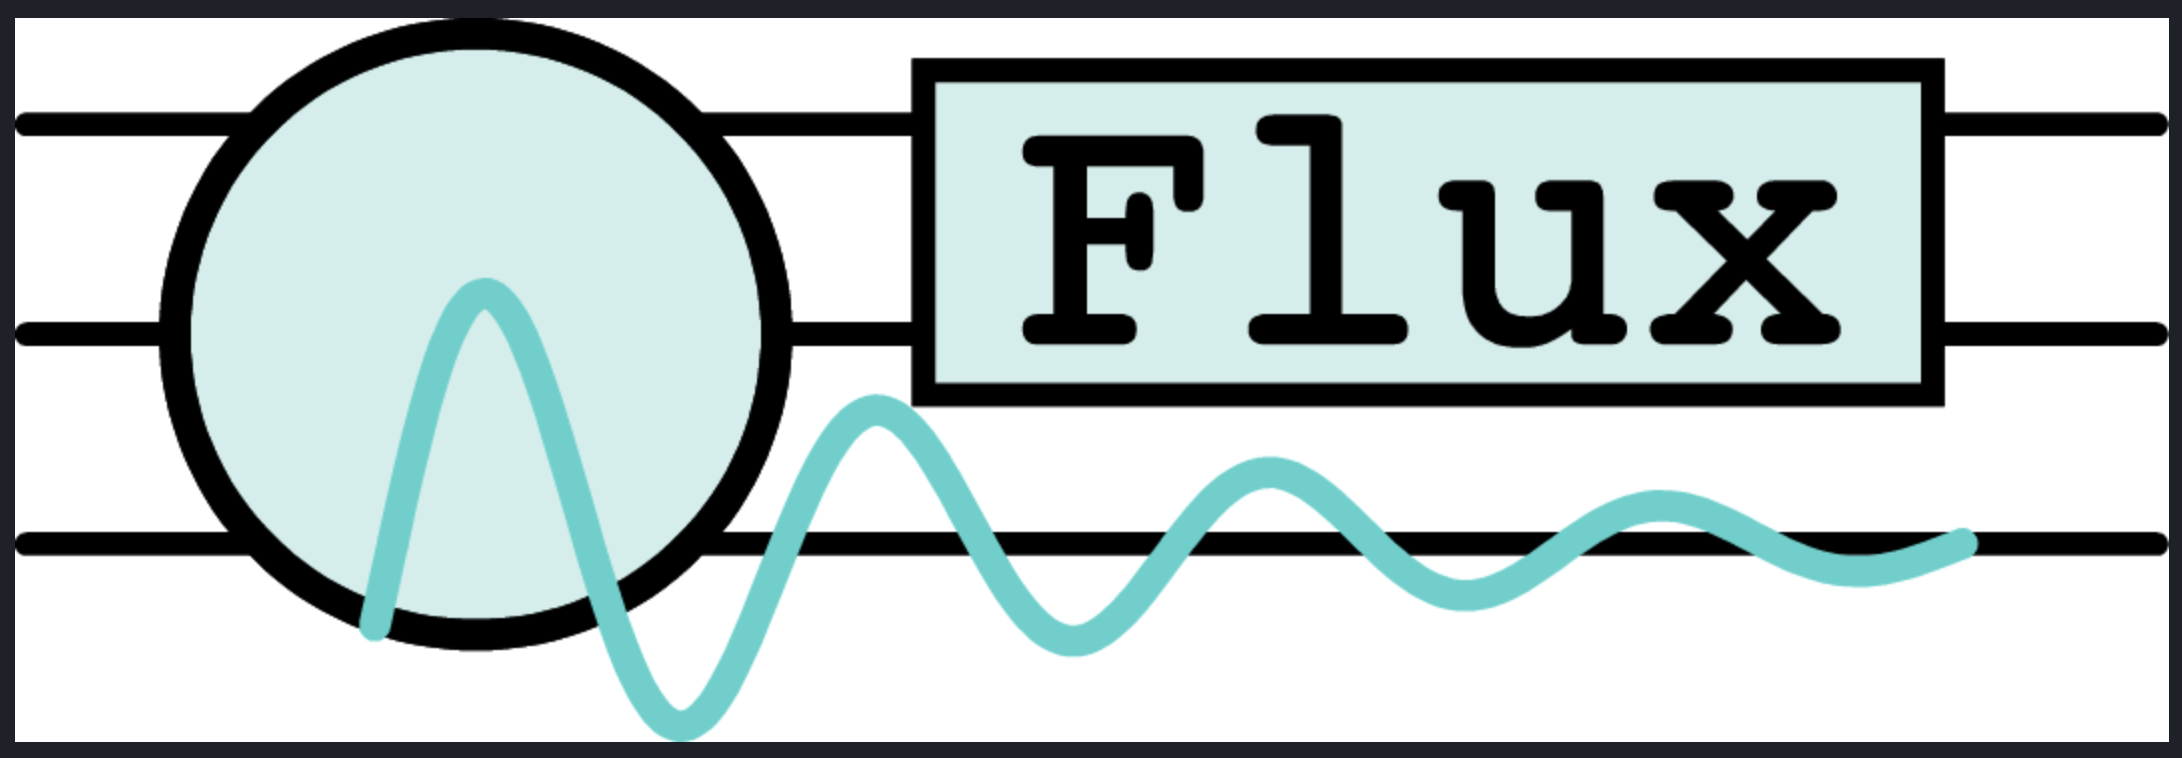
</div>


# Installation: Run the following cell to install QFlux in Colab

In [ ]:
!pip install qflux

# **QFlux Tutorial**

<h2> This notebook implements codes referenced in the Supporting Information for: </h2>

<h2> 
<b> QFlux: Quantum Circuit Implementations for Molecular Dynamics </b>
</h2>

<h2> <b> Part V: QMAD, A Module for Adaptive Variational Quantum Algorithms in Open Quantum Systems</b> </h2>

<h3> 
    <b> Authors: </b> <br><br>
Saurabh Shivpuje, Xiaohan Dan, Yuchen Wang, Brandon C. Allen, Delmar G. A. Cabral, Alexander V. Soudackov, Zixuan Hu, Ningyi Lyu, Eitan Geva, Victor S. Batista, and Sabre Kais</h3>

**Note:** Each section builds on the previous ones. **Execute the cells sequentially**, as later sections rely on functions and data defined earlier.

# Table of Contents

* Section 1

  - <a href="#ScriptSpt1pt1">Script S.1.1: QuTiP For Exact Solutions</a>

* Section 2

  - <a href="#ScriptSpt2pt1">Script S.2.1: Amplitude Damping Channel</a>

* Section 3

  - <a href="#ScriptSpt3pt1">Script S.3.1: FMO Complex Parameters</a>

  - <a href="#ScriptSpt3pt2">Script S.3.2: FMO Complex Plot</a>

* Section 4

  - <a href="#ScriptSpt4pt1">Script S.4.1: Vectorized Effective Hamiltonian</a>

* Section 5

  - <a href="#ScriptSpt5pt1">Script S.5.1: Defining Pool Of Operators/Gates</a>

* Section 6

  - <a href="#ScriptSpt6pt1">Script S.6.1: Amplitude Damping Channel</a>

* Section 7

  - <a href="#ScriptSpt7pt1">Script S.7.1: Preprocessing Hamiltonian For SSE Approach</a>

* Section 8

  - <a href="#ScriptSpt8pt1">Script S.8.1: Parallel Processing Of Trajectories</a>

* Section 9

  - <a href="#ScriptSpt9pt1">Script S.9.1: Setting Up Parameters For FMO Complex</a>

  - <a href="#ScriptSpt9pt2">Script S.9.2: Setting Up Parameters For Trajectory Method</a>

  - <a href="#ScriptSpt9pt3">Script S.9.3: Plot For FMO Complex Simulation Output</a>

# Section 1

## Script S.1.1: QuTiP For Exact Solutions <a name="ScriptSpt1pt1"></a>

In [2]:
from qutip import mesolve, Qobj

def qutip_prop(H, rho0, time_arr, c_ops, observable):
    """
    First import the mesolve function, which is used to solve master equations, and the Qobj class, which is used to represent quantum objects, from the QuTiP library.
    - H: Hamiltonian of the system (Qobj).
    - rho0: Initial density matrix (Qobj).
    - time_arr: Time array for dynamic simulation (array).
    - c_ops: List of collapse operators (list of Qobj), can be empty for Liouville equation.
    - observable: Operator for which the expectation value is to be calculated (Qobj).
    Returns:
    - expec_vals: List of expectation values of the observable over time.
    """
    result = mesolve(H, rho0, time_arr, c_ops, e_ops=observable)
    return result.expect


# Section 2

## Script S.2.1: Amplitude Damping Channel <a name="ScriptSpt2pt1"></a>

- **Pauli and ladder operators `sx`, `sy`**: $\sigma_x$, $\sigma_y$ define Pauli matrices; the lowering operator $\sigma^- = (\sigma_x + \mathrm{i}\sigma_y)/2$ for amplitude damping (it takes the excited state to the ground state).

- **Hamiltonian `H`**: an identity operator (no unitary evolution - dynamics are dominated by dissipation).

- **Trajectory parameters**: `tf`, `dt` set the simulation time window and step (in seconds);

- **Damping rate `gamma`**: a parameter $\gamma$ controlling the amplitude-damping strength.

- **Initial state `u0`**: $|u_0\rangle$ is prepared and normalized, and then converted to vectorized initial density matrix $\rho_0 = |u_0\rangle\langle u_0|$ for open-system propagation.

- **Observables `proj_ground` and `proj_excited`:** projectors onto $|0\rangle$ and $|1\rangle$, used to compute populations over time via `qutip_prop`.

- **Result**: `result` contains expectation values for the populations of the ground and excited states.

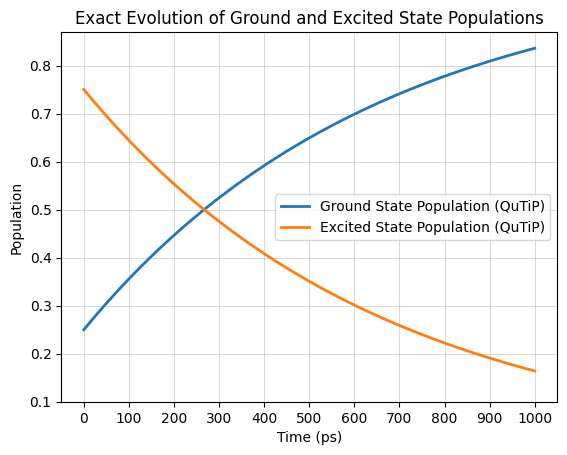

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Pauli matrices and lowering operator
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sp = (sx + 1j * sy) / 2
sm = Qobj(sp)  # collapse operator for amplitude damping

# Identity Hamiltonian (trivial in this case)
H = Qobj(np.eye(2, dtype=np.complex128))

# Time scale
tf = 1000e-12  # final time
dt = 1e-12  # time step
qt_times = np.arange(0, tf, dt)  # time array

# Amplitude damping rate
gamma = 1.52e9  # damping rate

# Initial state (normalize if necessary)
u0 = np.array([1 / 2, np.sqrt(3) / 2], dtype=np.complex128)
u0 = u0 / np.linalg.norm(u0)  # normalize the state
psi0 = Qobj(u0)  # initial state as Qobj
rho0 = psi0 * psi0.dag()

# Collapse operators
c_ops = [np.sqrt(gamma) * sm]  # amplitude damping

# Define projectors for ground and excited states
proj_excited = basis(2, 1) * basis(2, 1).dag()  # |1><1|
proj_ground = basis(2, 0) * basis(2, 0).dag()   # |0><0|

# Solve the master equation using mesolve
result = qutip_prop(H, rho0, qt_times, c_ops, [proj_ground, proj_excited])

# Extract ground and excited state populations
ground_population = result[0]  # <0|rho|0> (ground state population)
excited_population = result[1]  # <1|rho|1> (excited state population)

# Plotting results
line1 = plt.plot(qt_times * 1e12, ground_population, linewidth=2, label="Ground State Population (QuTiP)")
line2 = plt.plot(qt_times * 1e12, excited_population, linewidth=2, label="Excited State Population (QuTiP)")

# Extract colors from the lines
color1 = line1[0].get_color()
color2 = line2[0].get_color()

# Add points every 100 ps
point_indices = range(0, len(qt_times), 100)
#plt.scatter(qt_times[point_indices] * 1e12, ground_population[point_indices], color=color1, s=20, zorder=5)
#plt.scatter(qt_times[point_indices] * 1e12, excited_population[point_indices], color=color2, s=20, zorder=5)

# Add grid lines every 100 ps on x-axis and every 0.1 on y-axis
plt.xticks(np.arange(0, 1100, 100))
plt.yticks(np.arange(0.1, 0.9, 0.1))
plt.grid(True, which='major', linestyle='-', linewidth=0.5, alpha=0.7)

plt.xlabel('Time (ps)')
plt.ylabel('Population')
plt.legend(loc='center right')
plt.title('Exact Evolution of Ground and Excited State Populations')
plt.show()


# Section 3

## Script S.3.1: FMO Complex Parameters <a name="ScriptSpt3pt1"></a>

In [4]:
from qutip import Qobj
import numpy as np

# Hamiltonian (Unit: eV)
H = Qobj([
    [0, 0, 0, 0, 0],
    [0, 0.0267, -0.0129, 0.000632, 0],
    [0, -0.0129, 0.0273, 0.00404, 0],
    [0, 0.000632, 0.00404, 0, 0],
    [0, 0, 0, 0, 0],
])

alpha, beta, gamma = 3e-3, 5e-7, 6.28e-3 #Unit: fs (femtosecond)

# Define the alpha operators
Llist_f = [Qobj(np.diag([0] * i + [np.sqrt(alpha)] + [0] * (4 - i))) for i in range(1, 4)]

# Define the beta operators
Llist_f += [Qobj(np.array([[np.sqrt(beta) if i == 0 and j == k else 0 for j in range(5)] for i in range(5)])) for k in range(1, 4)]

# Define the gamma operator
L_temp = np.zeros((5, 5))
L_temp[4, 3] = np.sqrt(gamma)
Llist_f.append(Qobj(L_temp))


## Script S.3.2: FMO Complex Plot <a name="ScriptSpt3pt2"></a>

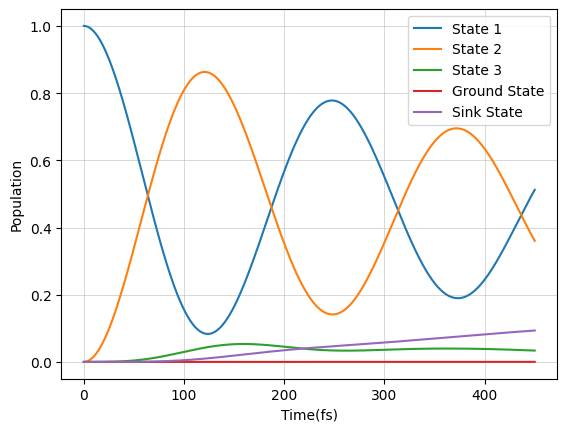

In [5]:
import matplotlib.pyplot as plt

# Measurement operators
Mexp_f = [
    Qobj(np.diag([0, 1, 0, 0, 0])),
    Qobj(np.diag([0, 0, 1, 0, 0])),
    Qobj(np.diag([0, 0, 0, 1, 0])),
    Qobj(np.diag([1, 0, 0, 0, 0])),
    Qobj(np.diag([0, 0, 0, 0, 1]))
]

# Time evolution
times = np.linspace(0.0, 450.0, 2000)
psi0_f = Qobj([[0], [1], [0], [0], [0]])

# Using qutip_propagation function
population = qutip_prop(H, psi0_f, times, Llist_f, Mexp_f)

# Plotting the results
fig, ax = plt.subplots()
labels = ["State 1", "State 2", "State 3", "Ground State", "Sink State"]
for expec, label in zip(population, labels):
    ax.plot(times, expec, label=label)
ax.set_xlabel('Time(fs)')
ax.set_ylabel('Population')
plt.grid(True, which='major', linestyle='-', linewidth=0.5, alpha=0.7)
ax.legend()
plt.show()


# Section 4

## Script S.4.1: Vectorized Effective Hamiltonian <a name="ScriptSpt4pt1"></a>

- **`vectorize_comm`**: builds the Hermitian part of the effective Hamiltonian $H_e = \mathbb{I} \otimes H - H^{\top} \otimes \mathbb{I}$

- **`VectorizedEffectiveHamiltonian`**: builds the effective Hamiltonian $H_{\mathrm{eff}} = H_e - \mathrm{i} H_a$, where the antiHermitian operator $H_a$ is defined as
$$
H_a = - \mathrm{i} \left[L^{\ast} \otimes L - \dfrac{1}{2}(\mathbb{I} \otimes L^{\dagger}L + L^{T}L^{*} \otimes \mathbb{I} ) \right]
$$
where $L$ is the Lindblad collapse operator (`lind`).

In [6]:
import numpy as np

def vectorize_comm(A):
    # Create an identity matrix with the same dimension as A
    iden = np.eye(A.shape[0])
    # Compute the vectorized commutator [A, .] as the Kronecker product
    return np.kron(iden, A) - np.kron(A.T, iden)

class VectorizedEffectiveHamiltonian_class:
    def __init__(self, He, Ha):
        self.He = He
        self.Ha = Ha

def VectorizedEffectiveHamiltonian(H, gamma, lind):
    # Create an identity matrix with the same dimension as H
    iden = np.eye(H.shape[0])
    d = H.shape[0]
    # Compute the vectorized commutator for the Hamiltonian H
    vec_H = vectorize_comm(H)
    # Initialize the result matrix with zeros (complex type)
    res = np.zeros((d**2, d**2), dtype=np.complex128)
    # Compute the conjugate of the Lindblad operator
    L_conj = lind.conj()
    L_dagger_L = L_conj.T @ lind
    # Compute the Lindblad contribution to the effective Hamiltonian
    res -= gamma * (np.kron(L_conj, lind) - (np.kron(iden, L_dagger_L) + np.kron(L_dagger_L.T, iden)) / 2)
    # Return an instance of the VectorizedEffectiveHamiltonian_class with vec_H and res
    return VectorizedEffectiveHamiltonian_class(vec_H, res)


# Section 5

## Script S.5.1: Defining Pool Of Operators/Gates <a name="ScriptSpt5pt1"></a>

In [7]:
from itertools import combinations, product
from qflux.variational_methods.qmad.ansatz import PauliOperator

# Define Pauli matrices
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sz = np.array([[1, 0], [0, 0]])

def build_pool(nqbit):
    pauliStr = ["sx", "sz", "sy"]
    res = []
    # Iterate over combinations of qubit indices and Pauli operators
    for order in range(1, 3):
        for idx in combinations(range(1, nqbit + 1), order):
            for op in product(pauliStr, repeat=order):
                res.append(PauliOperator(op, list(idx), 1, nqbit))
    return res


# Section 6

## Script S.6.1: Amplitude Damping Channel <a name="ScriptSpt6pt1"></a>

Simulation time: 1000.0000000000001 ps
Time step: 10.0 ps
Final Optimized Ansatz
Number of gates in final ansatz: 8
Final ansatz gates: ['sx1sy2', 'sy1sz2', 'sz1sy2', 'sy1sx2', 'sy1sz2', 'sx1sy2', 'sy2', 'sy1']
Number of time steps: 101


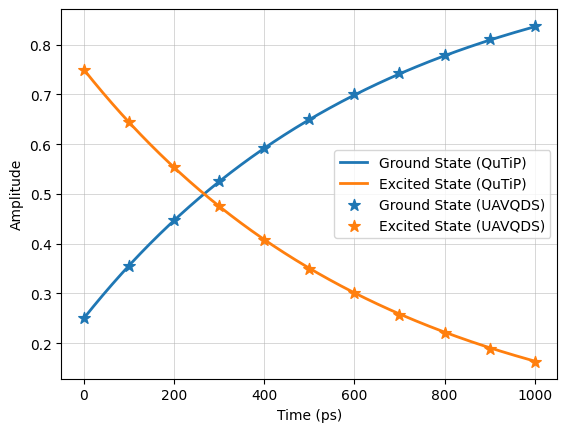

In [8]:
import numpy as np
from qflux.variational_methods.qmad.solver import solve_avq_vect
from qflux.variational_methods.qmad.effh import VectorizedEffectiveHamiltonian
from qflux.variational_methods.qmad.ansatz import build_pool, Ansatz
import matplotlib.pyplot as plt

sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sp = (sx + 1j * sy) / 2
Id = np.eye(2, dtype=np.complex128)

#-- build effective Hamiltonian for the vectorized density matrix
H = np.eye(2, dtype=np.complex128)
gamma = 1.52e9
lind = sp
H = VectorizedEffectiveHamiltonian(H, gamma, lind)

#-- initial state to build the initial pure state density matrix
u0 = np.array([1 / 2, np.sqrt(3) / 2], dtype=np.complex128) #it should be normalized initial state with 2^n length

#-- simulation time (tf) and time step (dt) (in seconds)
tf = 1000e-12
dt =   10e-12

#-- Initialize the ansatz and propagate the variational parameters and density matrix
ansatz = Ansatz(u0, relrcut=1e-6, vectorized=True)
res = solve_avq_vect(H, ansatz, [0, tf], dt, rk45=False)

#-- Print the optimized ansatz at the end of simulation
print("=" * 60)
print(f"Simulation time: {tf*1e12} ps")
print(f"Time step: {dt*1e12} ps")
print("=" * 60)
print("Final Optimized Ansatz")
print("=" * 60)
print(f"Number of gates in final ansatz: {len(res.A[-1])}")
print(f"Final ansatz gates: {res.A[-1]}")
print(f"Number of time steps: {len(res.t)}")
print("=" * 60)

#-- Extract diagonal elements from density matrices at each time step
excited = np.array([res.u[i][1, 1].real for i in range(len(res.u))])
ground = np.array([res.u[i][0, 0].real for i in range(len(res.u))])
times = np.array(res.t)

line_qt_1 = plt.plot(qt_times * 1e12, ground_population, label="Ground State (QuTiP)", linewidth=2, color='tab:blue')
line_qt_2 = plt.plot(qt_times * 1e12, excited_population, label="Excited State (QuTiP)", linewidth=2, color='tab:orange')
color_qt_1 = line_qt_1[0].get_color()
color_qt_2 = line_qt_2[0].get_color()

point_indices_qt = range(0, len(qt_times), 100)
#plt.scatter(qt_times[point_indices_qt] * 1e12, ground_population[point_indices_qt], color=color_qt_1, s=20, zorder=5)
#plt.scatter(qt_times[point_indices_qt] * 1e12, excited_population[point_indices_qt], color=color_qt_2, s=20, zorder=5)

point_indices = range(0, len(times), 10)
plt.scatter(times[point_indices] * 1e12, ground[point_indices],  color=color_qt_1, label="Ground State (UAVQDS)",  s=75, marker='*', zorder=5)
plt.scatter(times[point_indices] * 1e12, excited[point_indices], color=color_qt_2, label="Excited State (UAVQDS)", s=75, marker='*', zorder=5)

plt.xlabel("Time (ps)")
plt.ylabel("Amplitude")
plt.grid(True, which='major', linestyle='-', linewidth=0.5, alpha=0.7)
plt.gca().xaxis.set_major_locator(plt.matplotlib.ticker.MultipleLocator(200))
plt.gca().yaxis.set_major_locator(plt.matplotlib.ticker.MultipleLocator(0.1))
plt.legend()
plt.show()

# Section 7

## Script S.7.1: Preprocessing Hamiltonian For SSE Approach <a name="ScriptSpt7pt1"></a>

In [9]:
class EffectiveHamiltonian_class:
    def __init__(self, He, Ha, Llist, LdL):
        self.He = He  # Hermitian part
        self.Ha = Ha  # Anti-Hermitian part
        self.Llist = Llist  # List of Lindblad operators
        self.LdL = LdL  # List of L†L

def EffectiveHamiltonian(mats, Llist):
    """
    Create an EffectiveHamiltonian object based on provided parameters.
    :param mats: List of matrices (Hamiltonian terms).
    :param Llist: List of lists of Lindblad operators.
    :return: An instance of EffectiveHamiltonian_class.
    """
    He = sum(mats)  # Sum of Hamiltonian terms as Hermitian part
    Ha = 0.0  # Initialize anti-Hermitian part
    LdL = []  # Initialize the list for Lindblad operator products

    for  LL in Llist:
        for L in LL:
            L_dagger_L = (L.conj().T @ L)
            LdL.append(L_dagger_L)  # Append to LdL list
            Ha += L_dagger_L  # Sum for the anti-Hermitian part

    # Return the Effective Hamiltonian object
    return EffectiveHamiltonian_class(He, 0.5 * Ha, [L for LL in Llist for L in LL], LdL)


# Section 8

## Script S.8.1: Parallel Processing Of Trajectories <a name="ScriptSpt8pt1"></a>

In [10]:
from qflux.variational_methods.qmad.solver import solve_avq_trajectory
from multiprocessing import Pool

def run_trajectories(num_trajectory, H, ansatz, tf, dt):
    # Create a list of tuples with the required parameters for each trajectory
    param_list = [(H, ansatz, tf, dt) for _ in range(num_trajectory)]

    with Pool() as pool:
        results = pool.starmap(solve_avq_trajectory, param_list)

    return results


# Section 9

## Script S.9.1: Setting Up Parameters For FMO Complex <a name="ScriptSpt9pt1"></a>

In [11]:
#Hamiltonian
H = [
    [0, 0, 0, 0, 0],
    [0, 0.0267, -0.0129, 0.000632, 0],
    [0, -0.0129, 0.0273, 0.00404, 0],
    [0, 0.000632, 0.00404, 0, 0],
    [0, 0, 0, 0, 0],
]
H_fmo= np.pad(H, ((0, 3), (0, 3)), mode='constant')

alpha, beta, gamma = 3e-3, 5e-7, 6.28e-3

# Define the alpha operators
Llist_f = [(np.diag([0] * i + [np.sqrt(alpha)] + [0] * (4 - i))) for i in range(1, 4)]

# Define the beta operators
Llist_f += [(np.array([[np.sqrt(beta) if i == 0 and j == k else 0 for j in range(5)] for i in range(5)])) for k in range(1, 4)]

# Define the gamma operator
L_temp = np.zeros((5, 5))
L_temp[4, 3] = np.sqrt(gamma)
Llist_f.append(L_temp)
Llist_f_padded = [np.pad(matrix, ((0, 3), (0, 3)), mode='constant') for matrix in Llist_f]

#initial state
u0_fmo = np.zeros(8,dtype=np.complex128)
u0_fmo[1] = 1


## Script S.9.2: Setting Up Parameters For Trajectory Method <a name="ScriptSpt9pt2"></a>

In [12]:
from qflux.variational_methods.qmad.effh import EffectiveHamiltonian
from qflux.variational_methods.qmad.ansatz import Ansatz

# Guard for multiprocessing in Jupyter
if __name__ == "__main__":
    # Define your parameters (these are placeholders)
    tf = 450          # Final time
    dt = 5            # Time step
    num_trajectory = 200  # Number of trajectories
    H = EffectiveHamiltonian([H_fmo], [Llist_f_padded])  # Initialize the effective Hamiltonian
    ansatz = Ansatz(u0_fmo, relrcut=1e-5, vectorized=False)  # Create an Ansatz instance

    # Running the parallel trajectories
    results = run_trajectories(num_trajectory, H, ansatz, tf, dt)



## Script S.9.3: Plot For FMO Complex Simulation Output <a name="ScriptSpt9pt3"></a>

The QuTiP populations (`population`) are calculated in Section 3 in Scripts <a href="#ScriptSpt3pt1">S.3.1: FMO Complex Parameters</a> and <a href="#ScriptSpt3pt2">S.3.2: FMO Complex Plot</a>

In [13]:
import numpy as np

# Define the observables as diagonal matrices for expectation value calculations
Mexp_f = [
    np.diag([0, 1, 0, 0, 0, 0, 0, 0]),  # Observable 1
    np.diag([0, 0, 1, 0, 0, 0, 0, 0]),  # Observable 2
    np.diag([0, 0, 0, 1, 0, 0, 0, 0]),  # Observable 3
    np.diag([1, 0, 0, 0, 0, 0, 0, 0]),  # Observable 4
    np.diag([0, 0, 0, 0, 1, 0, 0, 0])   # Observable 5
]

# Initialize a list to store the average expectation values
average_expectation_values = []

# Loop over each trajectory to accumulate expectation values
for j in range(num_trajectory):
    # Loop over each observable defined in Mexp_f
    for k, observable in enumerate(Mexp_f):
        expectation_values = []  # List to hold expectation values for the current observable

        # Calculate expectation values for the current trajectory
        for i, psi in enumerate(results[j].psi):
            psi_dagger = np.conjugate(psi).T  # Conjugate transpose of the wave function
            rho = np.outer(psi, psi_dagger)    # Calculate the density matrix
            expectation_value = np.trace(np.dot(rho, observable))  # Compute the expectation value

            # Store the real part of the expectation value
            expectation_values.append(expectation_value.real)

        # Accumulate expectation values for averaging later
        if len(average_expectation_values) <= k:
            average_expectation_values.append(np.array(expectation_values))  # Initialize if not already done
        else:
            average_expectation_values[k] += np.array(expectation_values)  # Sum the values for this observable

# Convert time to femtoseconds for plotting (assuming results[0].t contains time data)
results_t_converted = [t for t in results[0].t]

# Average the accumulated expectation values over all trajectories
average_expectation_values = [ev / num_trajectory for ev in average_expectation_values]


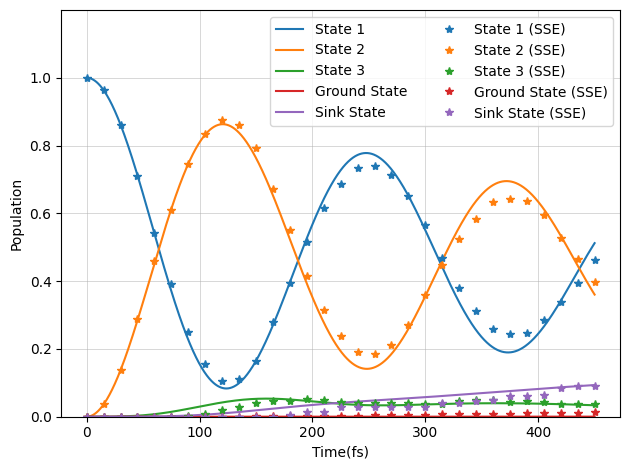

In [14]:
import matplotlib.pyplot as plt

# QuTiP time evolution
qutip_times = np.linspace(0.0, 450.0, 2000)
qutip_population = population

labels = ["State 1", "State 2", "State 3", "Ground State", "Sink State"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

counter = 0
for expec, label in zip(population, labels):
    plt.plot(qutip_times, expec, label=label, color=colors[counter])
    counter += 1

sse_labels = ["State 1 (SSE)", "State 2 (SSE)", "State 3 (SSE)", "Ground State (SSE)", "Sink State (SSE)"]

average_expectation_values = [np.asarray(arr) for arr in average_expectation_values]
results_t_converted = np.asarray(results_t_converted)
point_indices = np.arange(0, len(results_t_converted), 3)

counter = 0
for expec, label in zip(average_expectation_values, sse_labels):
    plt.plot(results_t_converted[point_indices], expec[point_indices], '*', label=label, color=colors[counter])
    counter += 1
plt.xlabel('Time(fs)')
plt.ylabel('Population')
plt.xticks(np.arange(0, 450, 100))
plt.yticks(np.arange(0, 1.2, 0.2))
plt.grid(True, which='major', linestyle='-', linewidth=0.5, alpha=0.7)
plt.legend(loc='upper right', ncol=2)
plt.ylim(0, 1.2)
plt.tight_layout()
plt.show()